# Visualization of bird sound files

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pydub import AudioSegment
from scipy import signal
from scipy.io import wavfile

In [19]:
# custom matplotlib style
usetex = True
fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.style.use('ggplot')
plt.rcParams.update(params)

## Pre-processing

### Conversion: MP3 to WAV

Here, we take all the MP3 bird sounds inside the "ALL BIRDS" folder, and convert them into WAV files. 

We have to do this because WAV is the most supported format to do sound processing.

<div class='alert alert-warning'>
This step will take some minutes. 
<div>

In [23]:
# Read the ALL BIRDS folder
folder_path = 'ALL BIRDS'
files = os.listdir(folder_path)

# Create folder for the WAV files
if not os.path.exists('all_birds_wav'):
        os.makedirs('all_birds_wav')
        
# Convert all sounds
for file in files:
    sound_id = file.split('-')[-1].split('.')[0]
    sound = AudioSegment.from_mp3(os.path.join(folder_path, file))
    sound = sound.set_channels(1) # stereo to mono 
    output_path = os.path.join('all_birds_wav', sound_id + '.wav')
    sound.export(output_path, format='wav')

In [22]:
# Read the Test Birds from Kasios
folder_path = 'Test Birds from Kasios'
files = os.listdir(folder_path)

# Create folder for the WAV files
if not os.path.exists('test_birds_kasios_wav'):
    os.makedirs('test_birds_kasios_wav')

# Convert all sounds
for file in files:
    sound_id = file.split('.')[0]
    sound = AudioSegment.from_mp3(os.path.join(folder_path, file))
    sound = sound.set_channels(1) # stereo to mono 
    output_path = os.path.join('test_birds_kasios_wav', sound_id + '.wav')
    sound.export(output_path, format='wav')    

### Import metadata

In [24]:
df = pd.read_csv('AllBirdsv4.csv')
df.head()

,File ID,English_name,Vocalization_type,Quality,Time,Date,X,Y
0,402254,Rose-crested Blue Pipit,call,no score,13:30,2/8/2018,49,63
1,406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133
2,405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76
3,405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125
4,401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123


## Visualization

### Temporal representation 

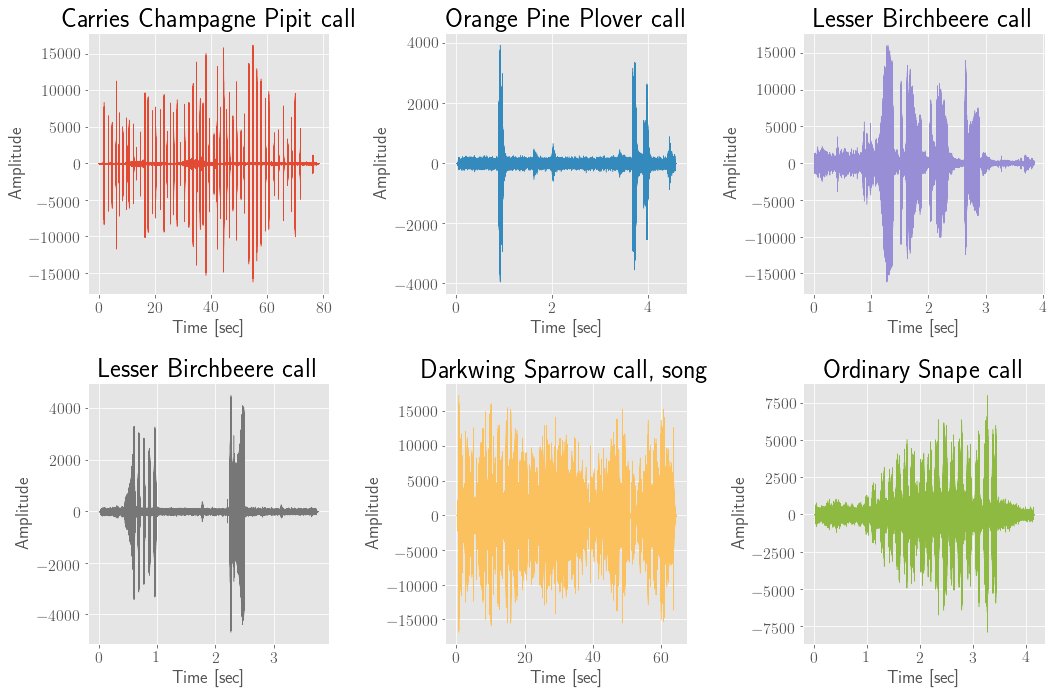

In [43]:
# take random samples
samples = df.sample(6)

folder_path = 'all_birds_wav'
fig = plt.figure(figsize=(15,10))
for i in range(6):
    # read wav file
    file_id = samples.iat[i, 0]
    f = os.path.join(folder_path, '{}.wav'.format(file_id))
    rate, data = wavfile.read(f)
    
    # plot the signal
    ax = fig.add_subplot(2, 3, i+1)
    times = np.arange(len(data))/float(rate)
    title = '{} {}'.format(samples.iat[i, 1], samples.iat[i, 2])
    ax.fill_between(times, data, color="C{}".format(i))
    ax.set_title(title)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Amplitude')
    
plt.tight_layout()

### Frequency representation (2D spectrogram)

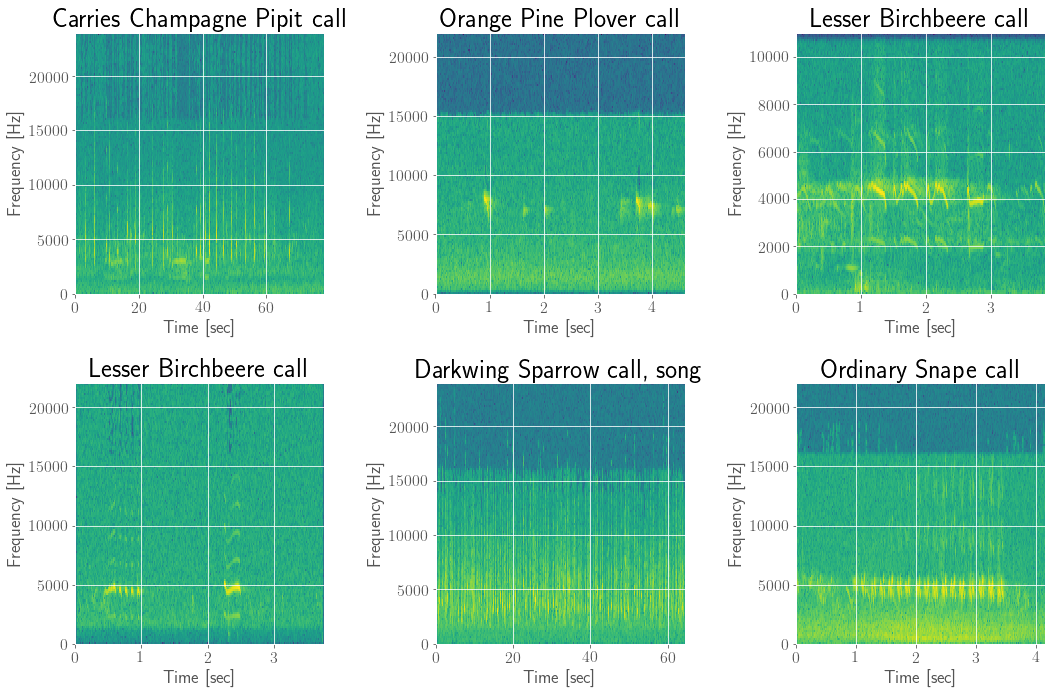

In [45]:
fig = plt.figure(figsize=(15,10))
for i in range(6):
    # read wav file
    file_id = samples.iat[i, 0]
    f = os.path.join(folder_path, '{}.wav'.format(file_id))
    rate, data = wavfile.read(f)

    # plot the spectrogram
    ax = fig.add_subplot(2, 3, i+1)
    title = '{} {}'.format(samples.iat[i, 1], samples.iat[i, 2])
    ax.specgram(data, Fs=rate)
    ax.set_title(title)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [Hz]')
    
plt.tight_layout()

## Analysing birds sounds

**Aim**: Analyse the Kasios birds tests records and verify from which species each record belongs.

### 1) Visually

In [26]:
# Get a Rose-Crested-Blue-Pipit sample sound (n°160293)
folder_path = 'all_birds_wav'
files = os.listdir(folder_path)

sounds = []
f = os.path.join(folder_path, "162563.wav")
rate, data = wavfile.read(f)
sounds.append(data[:500000])

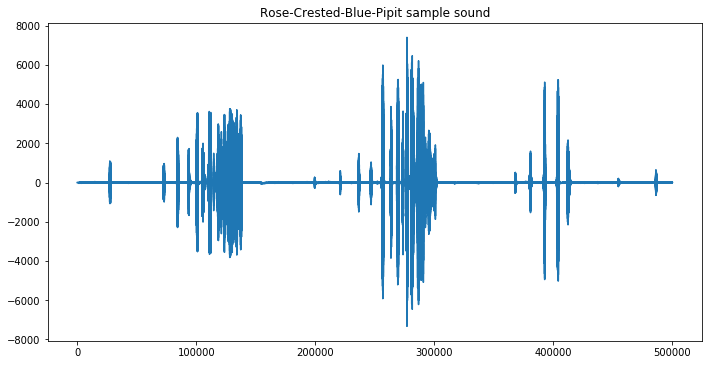

In [27]:
# visualize the signal
fig = plt.figure(figsize=(10,5))
plt.plot(sounds[0], c="C{}".format(0))
plt.tight_layout()
plt.title("Rose-Crested-Blue-Pipit sample sound")
plt.show()

In [28]:
# Get all tests sounds of Kasios
folder_path = 'test_birds_kasios'
files = os.listdir(folder_path)

for file in files:
    f = os.path.join(folder_path, file)
    rate, data = wavfile.read(f)
    sounds.append(data[:500000])
print(len(sounds))

16


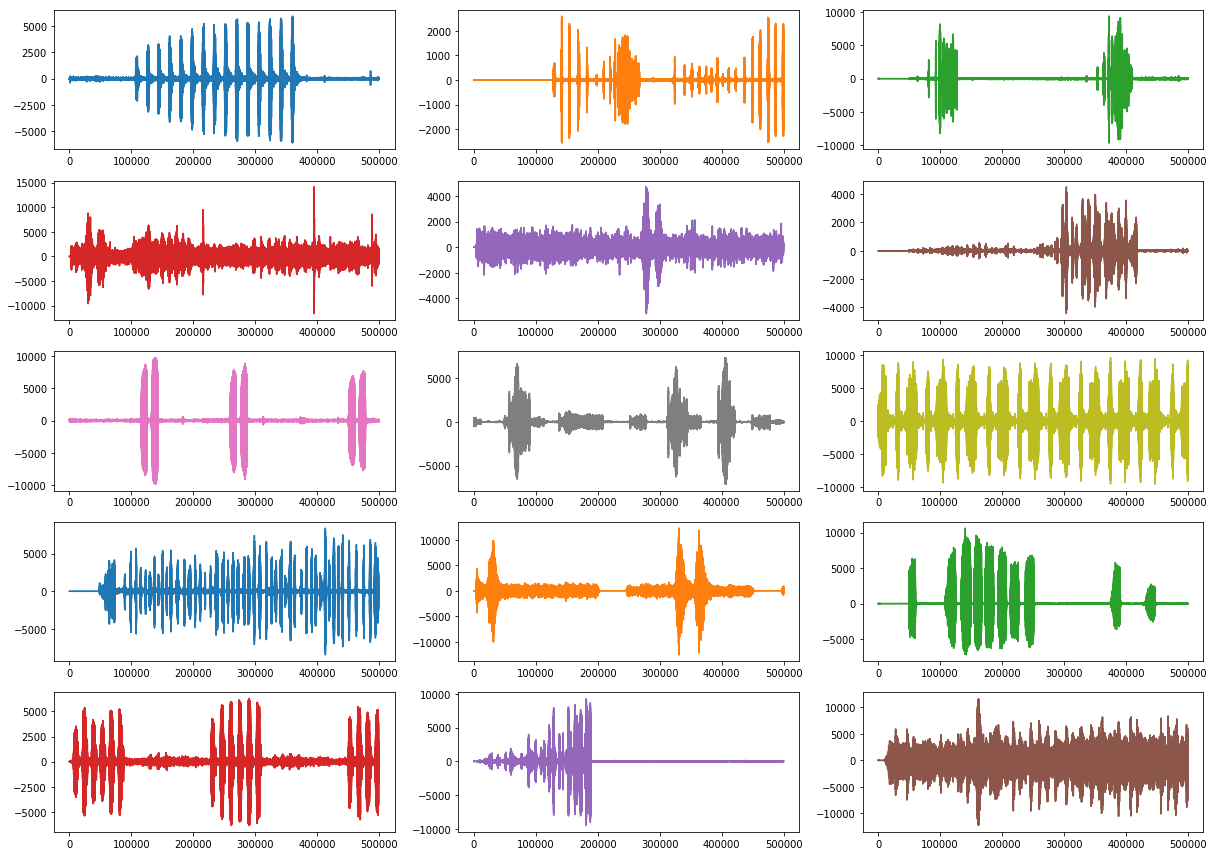

In [30]:
# visualize the signals
fig = plt.figure(figsize=(17,12))
for idx, sound in enumerate(sounds[1:]):
    ax = fig.add_subplot(5, 3, idx+1)
    ax.plot(sound, c="C{}".format(idx%9))
    
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
We can remark that most of the test records from Kasios are not from the Rose-Crested-Blue-Pipit species. The second record may belong to a Rose-Crested-Blue-Pipit.
<div>

### 2) Using Machine Learning

From literature, we have found several methods to classify sounds depending on the bird species:

- Logistic Regression
- k Nearest Neighbour (kNN) classifier with histogram-based features
- Support Vector Machines (SVM) with time-summarisation features
- Random Forest